In [ ]:
import os
import pickle
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_pitches(file_name, audio_type , frame_length=1024, hop_length=128):
    # Separate the file name and extension
    file_base_name, _ = os.path.splitext(os.path.basename(file_name))

    y, sr = librosa.load(file_name, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"filename: {file_base_name}, Duration: {duration} seconds")

    # Define frequency range
    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')

    # Calculate pitch values using pYIN
    pitch_values, voiced_flag, _ = librosa.pyin(y, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length, hop_length=hop_length)

    # print(f"len of pitch_values: {len(pitch_values)}")
    return pitch_values, voiced_flag

def plot_pitches_with_transcriptions(file_name, transcriptions, sr, audio_type, pitch_values, s_time=None, e_time=None):
    hop_length = 128

    # Create a time array for x-axis
    time = np.arange(len(pitch_values)) * hop_length / sr

    # Initialize modified pitch values
    modified_pitch_values = [np.nan] * len(pitch_values)

    for segment in transcriptions["segments_after_alignment"]:
        for word_info in segment["words"]:
            if "start" in word_info and "end" in word_info:
                start_time = word_info["start"]
                end_time = word_info["end"]

                # Find the index range corresponding to the word's time interval
                start_idx = int(start_time * sr // hop_length)
                end_idx = int(end_time * sr // hop_length)

                # Only keep pitches that correspond to transcribed words
                modified_pitch_values[start_idx:end_idx] = pitch_values[start_idx:end_idx]

    # Convert to log scale
    log_pitch_values = np.log(np.array(pitch_values) + 1e-10)
    modified_pitch_values = np.array(modified_pitch_values)
    modified_log_pitch_values = np.log(modified_pitch_values + 1e-10)  # This should work now

    s_idx = int(s_time * sr // hop_length)
    e_idx = int(e_time * sr // hop_length)

    # Plot modified log pitch values
    fig, ax = plt.subplots(figsize=(10, 2.3))
    ax.plot(time[s_idx:e_idx], modified_log_pitch_values[s_idx:e_idx], 'ro', label="Modified Log pYIN pitch values", markersize=4)  # 'ro' specifies red dots

    # Set the y-ticks and y-ticklabels
    note_names = [f"{note}{octave}" for octave in range(0, 7) for note in ['C', 'F#']]
    freqs = [note_to_freq(note_name) for note_name in note_names]
    ax.set_yticks(np.log(np.array(freqs) + 1e-10))
    ax.set_yticklabels(note_names)

    # Set y-axis limits
    lower_limit_log_freq = np.log(note_to_freq("C2") + 1e-10)
    upper_limit_log_freq = np.log(note_to_freq("C4") + 1e-10)
    ax.set_ylim([lower_limit_log_freq, upper_limit_log_freq])
    ax.set_xticklabels([])

    plot_transcriptions_and_save(ax, transcriptions, 'modified', file_name, s_time, e_time)

    # Initialize pitch_std_values with NaNs
    pitch_std_values = [np.nan] * len(modified_log_pitch_values)

    # Loop through each point in modified_log_pitch_values
    for i in range(len(modified_log_pitch_values)):
        # Create window centered at i
        window_start = max(0, i - 5)
        window_end = min(len(modified_log_pitch_values), i + 6)
        window_values = modified_log_pitch_values[window_start:window_end]

        # Check conditions
        valid_values = [val for val in window_values if not np.isnan(val)]

        # Condition 1: At least 5 non-NaN values in window
        if len(valid_values) < 5:
            continue

        # Condition 2: No five consecutive NaN values in the middle
        nan_streak = 0
        for val in window_values:
            if np.isnan(val):
                nan_streak += 1
                if nan_streak >= 5:
                    break
            else:
                nan_streak = 0
        if nan_streak >= 5:
            continue

        # Compute standard deviation
        std_value = np.nanstd(window_values)
        pitch_std_values[i] = std_value

    # Convert pitch_std_values to numpy array
    pitch_std_values = np.array(pitch_std_values)

    # Plot pitch_std_values
    fig, ax = plt.subplots(figsize=(10, 2.3))
    ax.plot(time[s_idx:e_idx], pitch_std_values[s_idx:e_idx], 'go', label="Pitch Std Values", markersize=4)
    ax.set_xlabel('Time (s)')
    ax.set_ylim([0, 0.10])
    ax.set_ylabel('STD value')
    ax.grid(True)
    plt.tight_layout()
    plt.savefig("fig-pitch-contour-std.pdf")
    plt.show()

def plot_transcriptions_and_save(ax, transcriptions, prefix, file_name, s_time, e_time):
    # ax.set_xlabel('Time (s)')
    ax.set_ylabel('Log Frequency (Log Hz)')
    # ax.set_title(f'Log-scaled Pitch Estimation with Transcriptions ({prefix})')

    for segment in transcriptions["segments_after_alignment"]:
        for word_info in segment["words"]:
            if "start" in word_info and "end" in word_info:

                start_time = word_info["start"]
                end_time = word_info["end"]
                word = word_info["word"]

                if(start_time >= s_time and start_time <= e_time and end_time >=s_time and end_time <e_time):
                  ax.text((start_time + end_time) / 2, ax.get_ylim()[1], word, color='black', ha='center', va='bottom', fontsize=12)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def note_to_freq(note_name):
    A4_freq = 440.0
    all_notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Extract the note and the octave from the note_name
    if note_name[-2] == '#':
        note = note_name[:-1]
        octave = int(note_name[-1])
    else:
        note = note_name[0]
        octave = int(note_name[1:])

    key_number = all_notes.index(note)
    return A4_freq * 2**((key_number + (octave - 4) * 12) / 12.0)

# Poetry

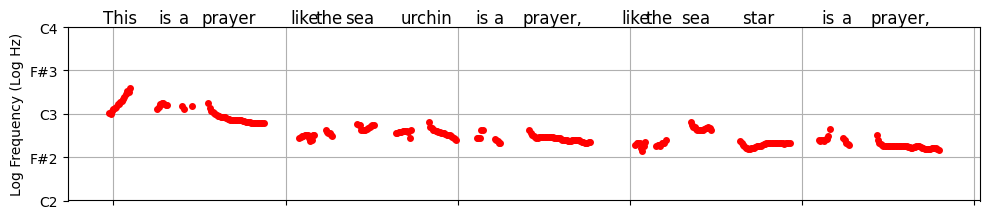

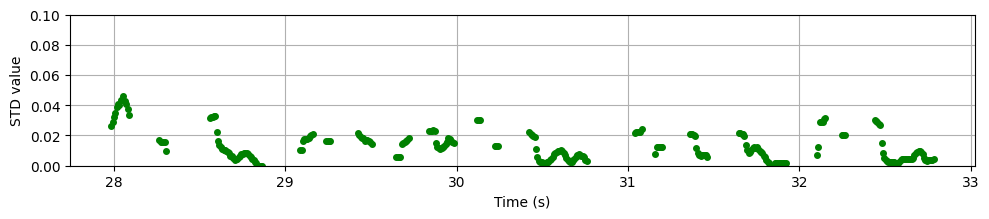

In [ ]:
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd

audio_type = 'poetry'

# Assign 'row' with your own dataframe that contains the columns 'Matching_MP3_File', 'transcriptions_list'
# row =

# Assign the folder path where 'Matching_MP3_File' is located
# audio_path =

mp3_file_path = audio_path + row['Matching_MP3_File']
transcriptions = row['transcriptions_list']

frame_length=1024
hop_length=128
sr=16000
y, sr = librosa.load(mp3_file_path, sr=sr)

# Define frequency range
fmin = librosa.note_to_hz('C2')
fmax = librosa.note_to_hz('C7')

# Calculate pitch values using pYIN
pitch_values, voiced_flag, _ = librosa.pyin(y, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length, hop_length=hop_length)
plot_pitches_with_transcriptions(mp3_file_path, transcriptions, sr, audio_type, pitch_values, s_time=27.9, e_time=32.9)

#Narration

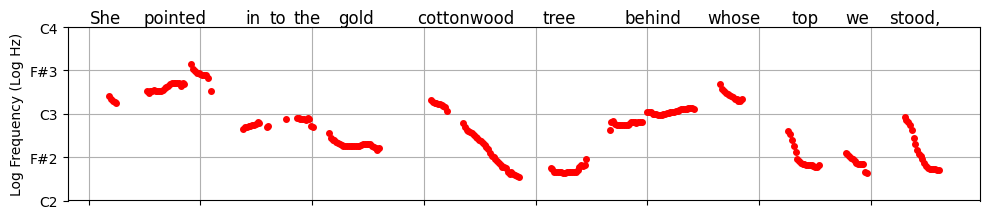

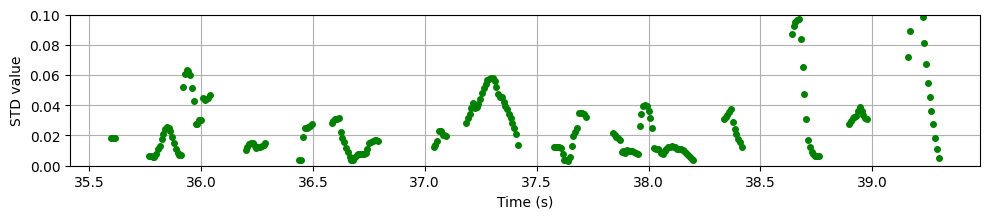

In [ ]:
audio_type = 'narration'
# Assign 'row' with your own dataframe that contains the columns 'ID', 'READER','BOOK ID', and 'transcriptions_list'
# row =

# Assign the folder path where a mp3 file is located
# audio_path =

# Extract ID, Reader, and SUBSET values
_id = str(row['ID'].iloc[0])  # Convert to str, in case they are not
reader = str(row['READER'].iloc[0])  # Convert to str, in case they are not
bookid = row['BOOK ID'].iloc[0]
file_name = f"{_id}_{reader}_{bookid}_combined.mp3"
mp3_file_path = os.path.join(audio_path, file_name)
transcription_value=row['transcriptions_list'].iloc[0]

frame_length=1024
hop_length=128
sr=16000
y, sr = librosa.load(mp3_file_path, sr=sr)

# Define frequency range
fmin = librosa.note_to_hz('C2')
fmax = librosa.note_to_hz('C7')

# Calculate pitch values using pYIN
pitch_values, voiced_flag, _ = librosa.pyin(y, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length, hop_length=hop_length)
plot_pitches_with_transcriptions(mp3_file_path, transcription_value, sr, audio_type, pitch_values, s_time=35, e_time=40)

# Vocal

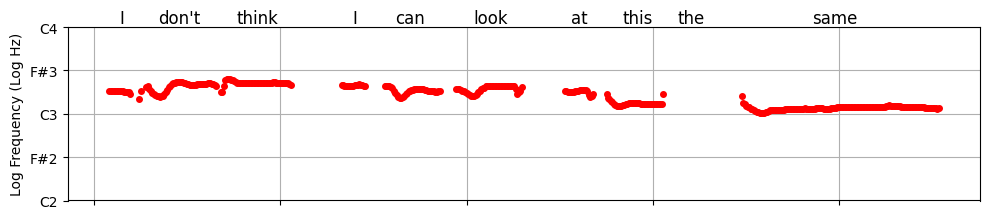

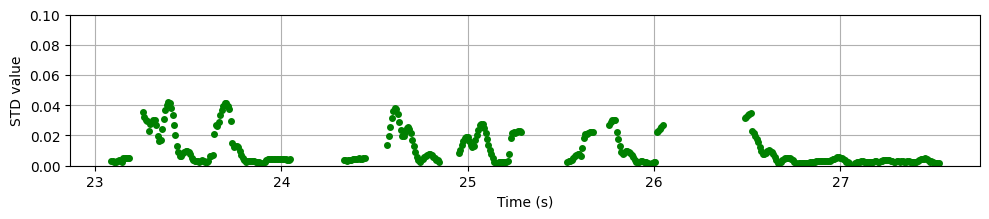

In [ ]:
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np
from scipy.stats import ks_2samp
import pandas as pd

audio_type = 'vocal'

# Assign 'row' with your own dataframe that contains the columns 'performance_id', 'transcriptions_list'
# row =

# Assign the folder path where a mp3 files is located
# audio_path =

performance_id = row['performance_id'].iloc[0]
mp3_file_path = os.path.join(audio_path, f"{performance_id}.mp3")  # Assuming the filename is performance_id.mp3
transcriptions = row['transcriptions_list'].iloc[0]

frame_length=1024
hop_length=128
sr=16000
# y, sr = librosa.load(mp3_file_path, sr=22050)
y, sr = librosa.load(mp3_file_path, sr=sr)

# Define frequency range
fmin = librosa.note_to_hz('C2')
fmax = librosa.note_to_hz('C7')

# Calculate pitch values using pYIN
pitch_values, voiced_flag, _ = librosa.pyin(y, sr=sr, fmin=fmin, fmax=fmax, frame_length=frame_length, hop_length=hop_length)
plot_pitches_with_transcriptions(mp3_file_path, transcriptions, sr, audio_type, pitch_values, s_time=23, e_time=28)